In [1]:
from typing import Annotated
import functools
import pandas as pd
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq

# from langchain_community.chat_models import ChatOllama
# from langchain_ollama import ChatOllama
# from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langchain_core.messages import HumanMessage
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

In [2]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    ask_human: bool
    execute_code: bool


@tool
def request_assistance():
    """Escalate the conversation to an expert. Use this if the search query is ambiguous or unclear, prompt the user with a clarifying question to gather specific attributes or details about the product they are searching for.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """
    return ""

@tool
def run_python_code():
    """
    Executes Python code on a Pandas DataFrame.

    This function should be called when a user requests an operation, transformation, 
    or analysis on a Pandas DataFrame. Examples include:
    - Filtering or transforming data
    - Adding, modifying, or removing columns
    - Performing statistical analyses or aggregations
    - Applying custom Python logic to the DataFrame

    The function takes user-provided Python code and a Pandas DataFrame as input, 
    applies the code to the DataFrame, and returns the modified DataFrame or 
    the result of the computation.

    Usage scenarios:
    - "Filter rows where column 'A' is greater than 10."
    - "Add a new column 'B' as the square of column 'A'."
    - "Calculate the mean of column 'C' grouped by column 'D'."

    Note: Ensure the code provided is safe and validated before execution.
    """
    return ""



def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    execute_code = False
    if response.tool_calls and response.tool_calls[0]["name"] == "request_assistance":
        ask_human = True
        
    if response.tool_calls and response.tool_calls[0]["name"] == "run_python_code":
        execute_code = True
        
    return {"messages": [response], "ask_human": ask_human, "execute_code": execute_code}


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        "messages": new_messages,
        "ask_human": False,
        "execute_code": False
    }

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)], "ask_human": False, "execute_code": False}


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    if state["execute_code"]:
        return "PythonExecutor"
    return tools_condition(state)

In [3]:
tavily_search = TavilySearchResults(max_results=2)

# llm = ChatOpenAI()
# llm = ChatOllama(model="llama3.1:8b")
model_name = "llama-3.1-70b-versatile"
llm = ChatGroq(
    model_name=model_name
)
llm_with_tools = llm.bind_tools([tavily_search, request_assistance, run_python_code])

In [4]:
data = pd.read_csv("data.csv", index_col=0)
model_name = "llama-3.1-70b-versatile"
llm_python_executor = ChatGroq(
    model_name=model_name
)

python_executor_agent = create_pandas_dataframe_agent(llm_python_executor, data, verbose=True, allow_dangerous_code=True)
python_executor_node = functools.partial(agent_node, agent=python_executor_agent, name="PythonExecutor")

In [5]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tavily_search]))
graph_builder.add_node("human", human_node)
graph_builder.add_node("PythonExecutor", python_executor_node)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "PythonExecutor": "PythonExecutor", "__end__": "__end__"},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge("PythonExecutor", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")

graph = graph_builder.compile(
    checkpointer=MemorySaver(),
    interrupt_before=[],
)

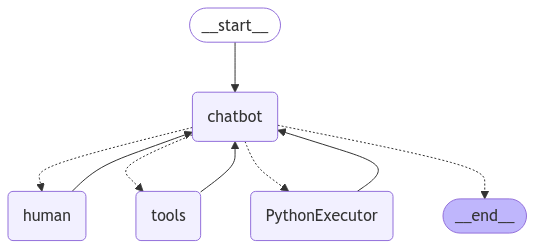

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
import uuid


def predict_react_agent_answer(example: dict):
    """Use this for answer evaluation"""

    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    messages = graph.invoke({"messages": ("user", example["input"])}, config)
    return {"response": messages["messages"][-1].content, "messages": messages}

In [8]:
example = {"input": "Hi, I am Rayen"}
response = predict_react_agent_answer(example)
response

{'response': 'Hi Rayen, how can I assist you today?',
 'messages': {'messages': [HumanMessage(content='Hi, I am Rayen', additional_kwargs={}, response_metadata={}, id='9f9818e3-44d7-4f68-abf6-759407e088ca'),
   AIMessage(content='Hi Rayen, how can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 831, 'total_tokens': 843, 'completion_time': 0.048, 'prompt_time': 0.141165391, 'queue_time': 0.003602190000000005, 'total_time': 0.189165391}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_b6828be2c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-7e53c7e4-e817-4134-b678-49b4b3d66302-0', usage_metadata={'input_tokens': 831, 'output_tokens': 12, 'total_tokens': 843})],
  'ask_human': False,
  'execute_code': False}}

In [9]:
example = {"input": "count the quantity for sku 1039"}
response = predict_react_agent_answer(example)
response

{'response': '<function=run_python_code>{"code": "df[df[\'sku\'] == 1039].shape[0]", "df": "pd.DataFrame({\'sku\': [1039, 2048, 1039, 4096, 1039], \'quantity\': [10, 20, 30, 40, 50]})"}',
 'messages': {'messages': [HumanMessage(content='count the quantity for sku 1039', additional_kwargs={}, response_metadata={}, id='92dcc7c8-d0d6-400d-b302-aefb88450e9b'),
   AIMessage(content='<function=run_python_code>{"code": "df[df[\'sku\'] == 1039].shape[0]", "df": "pd.DataFrame({\'sku\': [1039, 2048, 1039, 4096, 1039], \'quantity\': [10, 20, 30, 40, 50]})"}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 833, 'total_tokens': 907, 'completion_time': 0.296, 'prompt_time': 0.14507873, 'queue_time': 0.003971228000000021, 'total_time': 0.44107873}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_9260b4bb2e', 'finish_reason': 'stop', 'logprobs': None}, id='run-a3b65807-1047-464b-9add-26361e264cfd-0', usage_metadata={'input_tokens':